In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.flow import *
from clib.bellhop import *
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='profiles')

---
#### On prend 2 fichiers .arr ayant exactement les mêmes paramètres (profil, ALimits, NBeams, propriétés du fond). La seule différence est dans le nombre de récepteurs ... 

In [3]:
### avec 501 * 10001 = 5 millions de récepteurs
Arr1, Pos1 = s.load_dict('../Dictio', 'Arr1'), s.load_dict('../Dictio', 'Pos1') # cognac_2000m_test_A_full
print('Max. number of arrivals is %d.' %(np.max(Arr1['Narr'])))

Max. number of arrivals is 10.


In [4]:
### 51 * 101 = 5151 récepteurs
Arr2, Pos2 = s.read_arrivals_asc ('tests/med1_51_101.arr', Narrmx = 3883)

Max.number of arrivals for source index 0 is 3882


In [5]:
### 6 * 11 = 66 récepteurs 
Arr3, Pos3 = s.read_arrivals_asc ('tests/med1_OLD.arr', Narrmx = 7752)

Max.number of arrivals for source index 0 is 7751


---
#### Pour chaque fichier, On calcule 36 réponses impulsionnelles (aux mêmes points)

In [6]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 20., 30., 40., 50., 60., 70., 80., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)


Nombre total de réponses impulsionnelles :  36


---
#### Calcul des arrivées avec les 2 méthodes de détection

In [7]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

In [8]:
### CALCUL 1ERE ARRIVEE ET MAX D'AMPLITUDE

def time_calculation (Arr, Pos) : 
    
    ### Indices correspondants aux récepteurs choisis
    IRD = np.zeros_like(D)
    for i in range (D.size) : 
        IRD[i] = np.where(Pos['r']['depth']==D[i])[0][0]
    
    IRR = np.zeros_like(R)
    for i in range (R.size) : 
        IRR[i] = np.where(Pos['r']['range']==R[i])[0][0]
    
    ### Initialisation
    isd = 0          # choice of source depth
    seuil_d = 10.    # seuil de détection (dB)

    Tarr      = []
    TopBnc    = []
    BotBnc    = []
    SrcAngle  = []

    TarrA     = []
    TopBncA   = []
    BotBncA   = []
    SrcAngleA = []

    k = 0
    for i in range (IRD.size):
        for j in range(IRR.size):
            k+=1

            ird = int(IRD[i])     # choice of receiver depth
            irr = int(IRR[j])     # choice of receiver range
            ### Received level
            Narr = int(Arr['Narr'][irr,ird,isd])
            amp = Arr['A'][irr,:Narr, ird, isd]
            TL = -20*np.log10 (abs(amp))
            RL = SL - TL -NL +DI + PG
            ### Times
            times = Arr['delay'][irr, :Narr, ird, isd]

            ### first detected arrival 

            idx = np.where(RL > 10.)
            t_ok = times[idx]
            if len(t_ok) != 0 : 
                t_first = np.min(t_ok)
                idx_first = np.where(times==t_first)[0][0]
                # Chosen ray features
                NumTopBnc_f = Arr['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
                NumBotBnc_f = Arr['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
                SrcAngle_f  = Arr['SrcAngle'][irr, :Narr, ird, isd][idx_first]
                # Appends
                TopBnc.append(NumTopBnc_f)
                BotBnc.append(NumBotBnc_f)
                SrcAngle.append(SrcAngle_f)
                Tarr.append(t_first)           
            else : 
                TopBnc.append(np.NaN)
                BotBnc.append(np.NaN)
                SrcAngle.append(np.NaN)
                Tarr.append(np.NaN)


            #### max d'amplitude

            idx_max = np.where(RL==np.max(RL))[0][0]
            # Chosen ray features
            NumTopBnc_A = Arr['NumTopBnc'][irr, :Narr, ird, isd][idx_max]
            NumBotBnc_A = Arr['NumBotBnc'][irr, :Narr, ird, isd][idx_max]
            SrcAngle_A  = Arr['SrcAngle'][irr, :Narr, ird, isd][idx_max]
            # Appends
            TopBncA.append(NumTopBnc_A)
            BotBncA.append(NumBotBnc_A)
            SrcAngleA.append(SrcAngle_A)
            TarrA.append(times[idx_max])

    Time = np.array(Tarr)
    TimeA = np.array(TarrA)
    
    return Time, TimeA

In [9]:
Time1, Time1A   = time_calculation (Arr1, Pos1)   # 5millions récepteurs : Narrmx = 10
Time2, Time2A = time_calculation (Arr2, Pos2)     # 5000 récepteurs : Narrmx = 3900
Time3, Time3A = time_calculation (Arr3, Pos3)     # 66 récepteurs : Narrmx = 7800

---
#### Différence de temps d'arrivées entre Narrmx = 7800 et Narrmx = 3900 

In [10]:
Time3 - Time2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

#### Différence de temps d'arrivées entre Narrmx = 3900 et Narrmx = 10

In [11]:
Time2 - Time1

array([-3.3569000e-04, -5.2947100e-02, -4.4273400e-02, -3.8119510e-01,
       -6.8358230e-01, -5.3597640e-01, -9.4947000e-03, -1.9515113e+00,
       -2.3948708e+00,  0.0000000e+00, -5.0173700e-02, -5.7230000e-04,
       -3.7294960e-01, -5.5675500e-02, -1.1545560e-01, -5.3058600e-02,
       -1.8189354e+00, -3.9264700e-02, -1.6154760e-02, -7.0906700e-02,
       -1.0281000e-03, -2.5932300e-02, -2.5231930e-01, -5.3081130e-01,
       -1.0183831e+00, -2.7517700e-01,            nan, -1.3928890e-02,
       -4.8107100e-02, -5.6806500e-02, -1.0491750e-01, -3.0397030e-01,
       -4.8960880e-01, -1.5464800e-02, -7.5774760e-01, -1.1465950e+00])

In [14]:
print('La différence max est de %.2fs.' %np.max(abs(Time2[~np.isnan(Time1)] - Time1[~np.isnan(Time1)])))

La différence max est de 2.39s.


---
#### Régressions linéaires : range = f(time)

In [15]:
### On connaît le range, la profondeur et la distance source-récepteur pour chacune des vignettes

REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R
    
PROF = np.zeros(D.size*R.size)
for k in range (D.size) :
    PROF[k*R.size:(k+1)*R.size] = D[k]

D_EQ = np.sqrt((REAL_RANGE - 0)**2 + (PROF - Pos1['s']['depth'][0])**2)

In [16]:
### Régressions linéaires
res1 = np.polyfit(Time1[~np.isnan(Time1)], REAL_RANGE[~np.isnan(Time1)],1)
res2 = np.polyfit(Time2, REAL_RANGE,1)

In [17]:
### autre méthode, qui nous donne le coef de détermination r²
slope1, intercept1, r_value1, _, _ = stats.linregress(Time1[~np.isnan(Time1)], REAL_RANGE[~np.isnan(Time1)])
slope2, intercept2, r_value2, _, _ = stats.linregress(Time2, REAL_RANGE)
#To get coefficient of determination (r_squared)
print("Narrmx = 10    : r-squared = ", r_value1**2)
print("Narrmx = 3900  : r-squared = ", r_value2**2)

Narrmx = 10    : r-squared =  0.9992517417330554
Narrmx = 3900  : r-squared =  0.9999643028339533


In [18]:
print('Narrmx = 10     : pente = %.1f m/s.    (5millions de récepteurs)' %res1[0])
print('Narrmx = 3900   : pente = %.1f m/s.    (<= 5000 récepteurs)' %res2[0])

Narrmx = 10     : pente = 1477.9 m/s.    (5millions de récepteurs)
Narrmx = 3900   : pente = 1511.3 m/s.    (<= 5000 récepteurs)


---
#### Erreur en distance en calculant la range suivant les 2 régressions linéaires précédentes

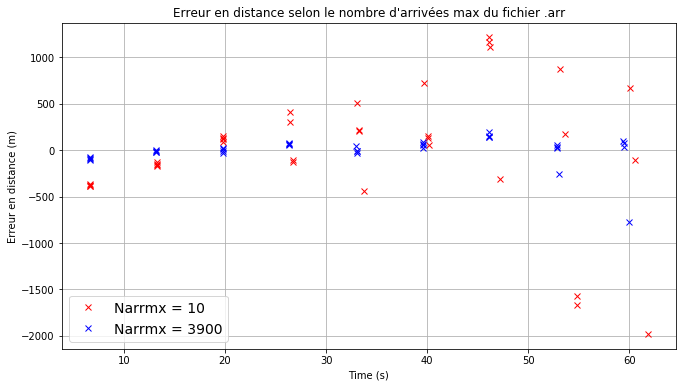

In [19]:
plt.figure(figsize=(11,6))
plt.plot (Time1, REAL_RANGE - (res1[0]*Time1 +res1[1]), 'rx', label = 'Narrmx = 10')
plt.plot (Time2, REAL_RANGE - (res2[0]*Time2 +res2[1]), 'bx', label = 'Narrmx = 3900')
plt.title ("Erreur en distance selon le nombre d'arrivées max du fichier .arr")
plt.xlabel('Time (s)')
plt.ylabel('Erreur en distance (m)')
plt.grid()
plt.legend(loc=3, fontsize=14)
plt.show()

Dans le code Bellhop, il existe une variable  **ArrivalsStorage = 20.e6** qui représente le nombre d'arrivées qui peuvent être stockées.   


Lorsque l'on définit un nombre de récepteurs Nr, Arrivals storage est divisé par Nr pour obtenir le nombre d'arrivées disponible pour chaque récepteur. Finalement, le nobmre maximal d'arrivées (Narrmx) par récepteur est défini tel que  :   

$$ 
Narrmx = max (\frac{ArrivalsStorage}{Nr} , 10 )
$$

---


- Si on travaille avec **5.000 récepteurs** : Narrmx = max (20.e6 / 5000, 10) = max (4000, 10) : on peut stocker jusqu'à **4000 arrivées**. 


- Si on travaille avec **5 millions de récepteurs** :  Narrmx = max (20.e6 / 5.e6, 10) = max (4, 10) : on travaille alors avec **10 arrivées**. Or, ce sont les arrivées ayont la plus grande amplitude qui sont choisies (et non pas les 10 premières arrivées), d'où les différences de temps d'arrivée observées précédemment.

---

**CONCLUSION : Il faut travailler avec un nombre raisonnable de récepteurs (inf. à 5000) afin d'avoir un nombre d'arrivées suffisant pour décrire correctement les réponses impulsionnelles.**